# 三次样条插值原理及实现
> 参考[python数据分析系列——三次样条插值理论推导、自定义实现与scipy实现](https://zhuanlan.zhihu.com/p/672601034?utm_id=0)
> 三对角求解参考[三对角线性方程组(tridiagonal systems of equations)的求解, TDMA算法](https://blog.csdn.net/jclian91/article/details/80251244)
> 并在原文基础上做了些改动:
> 1. 支持端点之外的插值;
> 2. 数据存储保存在三个向量当中, 而不是保存在一个矩阵中, 节约存储空间
> 3. 系数求解没有采用np自带的求解方法而是自己实现的三对角的求解法, 支持将算法移植到c++/c等.

## 1. 简介
在区间段$[a, b]$上划分为$[(x_0, x_1), (x_1, x_2), ..., (x_{n-1}, x_{n})]$，其中$a=x_0, b=x_n$, 因此有n+1个点和n个区间段。

三次样条就是说每个小区间的曲线是一个三次方程，三次样条方程满足以下条件：
1. 在每个分段小区间$S(x_i)=y_i$上，$S(x)=S_i(x)$都是一个三次方程
2. 满足插值条件，即$S(x_i)=y_i, i=(0,1,...,n)$
3. 曲线光滑，即$S(x)$, $S'(x)$, $S''(x)$ 连续


而三次方程可以构造成如下形式:  
$S_i(x)=a_i+b_ix+c_ix^2+d_ix^3$

从$S_i(x)$可以看出每个小区间有四个未知数 $a_i, b_i, c_i, d_i$ , 有n个小区间，则有4n个未知数，要解出这些未知数，则我们需要4n个方程来求解。

## 2. 求解条件

我们要找出4n个方程来求解4n个未知数

首先，由于所有点必须满足插值条件(条件 2)，$S(x_i)=y_i, i=(0,1,...,n)$, 除了两个端点，所有n-1个内部点的每个点都满足$S_i(x_{i+1})=y_{i+1}, S_{i+1}(x_{i+1})=y_{i+1}$, 即$S(x)$连续, 前后两个分段三次方程，则有2(n-1)个方程，再加上两个端点分别满足第一个和最后一个三次方程，则总共有2n个方程；

其次，n-1个内部点的一阶导数应该是连续的，即在第 i 区间的末点和第 i+1 区间的起点是同一个点，它们的一阶导数应该也相等，即 $S_i'(x_{i+1})=S_{i+}'(x_{i+1})$则有n-1个方程

另外，内部点的二阶导数也要连续，即$S_i''(x_{i+1})=S_{i+}''(x_{i+1})$,也有n-1个方程

现在总共有4n-2个方程了，还差两个方程就可以解出所有未知数了，这两个方程我们通过边界条件得到。

有三种边界条件：自然边界，固定边界，非节点边界

1. 自然边界 ( Natural Spline )：指定端点二阶导数为0，$f_0''(x_0)=0=f_{n-1}''(x_n)$
2. 固定边界 ( Clamped Spline ): 指定端点一阶导数，这里分别定为A和B。即 $f'_0(x_0)=A,\quad f_{n-1}'(x_n)=B$
3. 非扭结边界( Not-A-Knot Spline ): 强制第一个插值点的三阶导数值等于第二个点的三阶导数值，最后第一个点的三阶导数值等于倒数第二个点的三阶导数值. 即 $f'''_0(x_0)=f'''_1(x_1) \quad and \quad f'''_{n-2}(x_{n-1})=f'''_{n-1}(x_n) $

## 3. 具体推导
### 3.1 根据插值和导数连续的条件设置方程
每一个区间段的三次函数设为$f_i(x), i=[0,...,n-1]$ 则有
$$
\begin{aligned} f_{i}(x) &=a_{i}+b_{i}\left(x-x_{i}\right)+c_{i}\left(x-x_{i}\right)^{2}+d_{i}\left(x-x_{i}\right)^{3} \\ f_{i}^{\prime}(x) &=b_{i}+2 c_{i}\left(x-x_{i}\right)+3 d_{i}\left(x-x_{i}\right)^{2} \\ f_{i}^{\prime \prime}(x) &=2 c_{i}+6 d_{i}\left(x-x_{i}\right) \end{aligned}
$$

1. 根据插值定义，每一段函数的左端点等于其函数值，可得n个方程
   $$\begin{aligned} & f_i(x_i) = a_i+b_i(x_i-x_i)+c_i(x_i-x_i)^2+d_i(x_i-x_i)^3 = a_i \\ &\Longrightarrow a_i = y_i ,其中i=[0,...,n-1] \end{aligned} \tag{1}$$
2. 根据插值定义，每一段函数的右边端点等于其函数值，可得n个方程
   $$\begin{aligned} &f_i(x_{i+1}) = a_i+b_i(x_{i+1}-x_i)+c_i(x_{i+1}-x_i)^2+d_i(x_{i+1}-x_i)^3 ,令h_i=x_{i+1}-x_i\\ &\Longrightarrow a_i+h_ib_i+h_i^2c_i+h_i^3d_i = y_{i+1} ,其中i=[0,...,n-1] \end{aligned} \tag{2}$$
3. 根据一阶导数连续条件，除首位端点外，中间n-1个端点的左右一阶导数相等，可得n-1个方程
   $$\begin{aligned} &f'_i(x_{i+1}) = f'_{i+1}(x_{i+1}) \\ &\Longrightarrow b_i+2c_i(x_{i+1}-x_i)+3d_i(x_{i+1}-x_i)^2 = b_{i+1}+2c_{i+1}(x_{i+1}-x_{i+1})+3d_{i+1}(x_{i+1}-x_{i+1})^2,\\ &\Longrightarrow b_i+2c_ih_i+3d_ih_i^2 = b_{i+1},其中i=[0,...,n-2] \end{aligned} \tag{3}$$
4. 根据二阶导数连续条件，除首位端点外，中间n-1个端点的左右二阶导数相等，可得n-1个方程
$$\begin{aligned} &f''_i(x_{i+1}) = f''_{i+1}(x_{i+1}) \\ &\Longrightarrow 2c_i+6d_i(x_{i+1}-x_i) = 2c_{i+1}+6d_{i+1}(x_{i+1}-x_{i+1}),\\ &\Longrightarrow 2c_i+6d_ih_i = 2c_{i+1},其中i=[0,...,n-2] \end{aligned} \tag{4} $$


理论上来说可以对上面的4n个方程（加上边界条件）和未知数直接求解，不过这样效率会比较低，建议可以先人工进行消元,注意下面消元得时候i的下标。

### 3.2 方程的消元过程
(略)
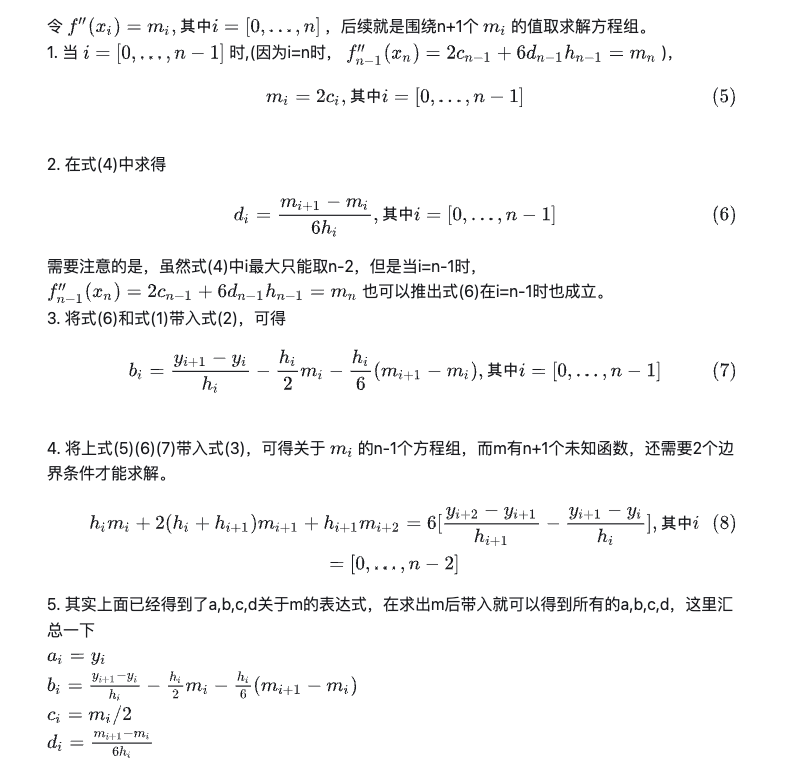

### 3.3 消元结果
1. 自然边界 (Natural Spline)
需满足如下两个边界条件
$$f''0(x_0) = m_0 = 0$$
$$f''{n-1}(x_n) = m_n = 0$$
推导结果为:
$$ \begin{bmatrix} 2 & 0 &0 &0 &\cdots &0 \\ h_0 & 2(h_0+h_1) & h_1 & 0 &\cdots &0 \\ 0 & h_1 & 2(h_1+h_2) & h_2 &\cdots &0 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 0 &\vdots & 0 &h_{n-2} &2(h_{n-2}+ h_{n-1})&h_{n-1}\\ 0 &\vdots &\vdots& 0 &0 &2 \end{bmatrix} \begin{bmatrix} m_0 \\ m_1 \\ m_2 \\ \vdots \\ m_{n-1} \\ m_{n} \end{bmatrix} = 6 \begin{bmatrix} 0 \\ \frac{y_2-y_1}{h_1} - \frac{y_1-y_0}{h_0} \\ \frac{y_3-y_2}{h_2} - \frac{y_2-y_1}{h_1} \\ \vdots \\ \frac{y_n-y_{n-1}}{h_{n-1}} - \frac{y_{n-1}-y_{n-2}}{h_{n-2}} \\ 0 \end{bmatrix} $$
3. 固定边界 (Clamped Spline)
$$f'0(x_0) = b_0+2c_0(x_0-x_0)+3d_i(x_0-x_0)^2= b_0 = \frac{y_1-y_0}{h_0}-\frac{h_0}{2}m_0-\frac{h_0}{6}(m_1-m_0) = A$$
化简得: $h_0m_0+2h_0m_1 = 6[\frac{y_1-y_0}{h_0} -A]$
$$f'{n-1}(x_n) = b_{n-1}+2c_{n-1}(x_n-x_{n-1})+3d_{n-1}(x_n-x_{n-1})^2 = b_{n-1}+2c_{n-1}h_{n-1}+3d_{n-1}h_{n-1}^2 = B$$
将前面推导过的b、c、d和m的关系式(5)(6)(7)带入,化简可得：$h_{n-1}m_{n-1}+2h_{n-1}m_n = 6[B - \frac{y_n-y_{n-1}}{h_{n-1}}]$
推导结果为:
$$ \begin{bmatrix} 2h_0 & h_0 &0 &0 &\cdots &0 \\ h_0 & 2(h_0+h_1) & h_1 & 0 &\cdots &0 \\ 0 & h_1 & 2(h_1+h_2) & h_2 &\cdots &0 \\ \vdots & \ddots  & \ddots  & \ddots  & \vdots  \\ 0 &\vdots & 0 &h_{n-2} &2(h_{n-2}+ h_{n-1})&h_{n-1}\\ 0 &\vdots &\vdots& 0 &h_{n-1} &2h_{n-1} \end{bmatrix} \begin{bmatrix} m_0 \\ m_1 \\ m_2 \\ \vdots \\ m_{n-1} \\ m_{n} \end{bmatrix} = 6 \begin{bmatrix} \frac{y_1-y_0}{h_0} - A  \\ \frac{y_2-y_1}{h_1} - \frac{y_1-y_0}{h_0} \\ \frac{y_3-y_2}{h_2} - \frac{y_2-y_1}{h_1} \\ \vdots  \\ \frac{y_n-y_{n-1}}{h_{n-1}} - \frac{y_{n-1}-y_{n-2}}{h_{n-2}} \\ B-\frac{y_n-y_{n-1}}{h_{n-1}} \end{bmatrix} $$
5. 非扭结边界 (Not-A-Knot Spline)
$$f'''0(x_0) =f'''_1(x_1) \rightarrow 6d_0 = 6d_1$$
带入前面的d和m的关系式并化简可得：$-h_1m_0+(h_0+h_1)m_1 + h_0m_2 = 0$
同理
$$f'''{n-2}(x_{n-1}) =f'''{n-1}(x{n}) \rightarrow 6d_{n-2} = 6d_{n-1} $$
带入前面的d和m的关系式并化简可得：$-h_{n-1}m_{n-2}+(h_{n-2}+h_{n-1})m_{n-1} + h_{n-2}m_{n} = 0$
推导结果为:
$$ \begin{bmatrix} -h_1 & h_0+h_1 &-h_0 &0 &\cdots &0 \\ h_0 & 2(h_0+h_1) & h_1 & 0 &\cdots &0 \\ 0 & h_1 & 2(h_1+h_2) & h_2 &\cdots &0 \\ \vdots & \ddots  & \ddots  & \ddots  & \vdots  \\ 0 &\vdots & 0 &h_{n-2} &2(h_{n-2}+ h_{n-1})&h_{n-1}\\ 0 &\vdots &\vdots& -h_{n-1} &h_{n-2}+h_{n-1} &-h_{n-2} \end{bmatrix} \begin{bmatrix} m_0 \\ m_1 \\ m_2 \\ \vdots \\ m_{n-1} \\ m_{n} \end{bmatrix} = 6 \begin{bmatrix} 0  \\ \frac{y_2-y_1}{h_1} - \frac{y_1-y_0}{h_0} \\ \frac{y_3-y_2}{h_2} - \frac{y_2-y_1}{h_1} \\ \vdots  \\ \frac{y_n-y_{n-1}}{h_{n-1}} - \frac{y_{n-1}-y_{n-2}}{h_{n-2}} \\ 0 \end{bmatrix} $$



## 4 Python 实现
根据上述3.3中的推导结果写出函数, 这里在知乎连接的基础上扩展了插值范围, 超过边界点的值继续用最边界的函数, 可在一小范围内正确.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 随便创建一些节点
x = np.array([1,2,3,5,7,9,11])
y = np.sin(x)+np.random.normal(len(x))
xq = np.arange(0, 12, 0.1) # 插值点

### 4.1 自然边界条件

In [9]:
class Natural_cubic_spline:
    def __init__(self,x,y):
        self.x = np.array(x)  #n个点的x值
        self.y = np.array(y)  #n个点的y值
        self.h = self.x[1:] - self.x[:-1]  #n-1个值
        self.dy = self.y[1:] - self.y[:-1] #n-1个值

    def _gen_equation(self):
        #单独定义函数：生成方程的系数
        #-----------------------------
        v1 = self.h.copy() #v1表示对H矩阵对角线左侧的值
        v1[-1] = 0        

        v2 = 2*np.ones(len(self.x)) #v2表示对H矩阵对角线值 
        v2[1:-1] = 2*(self.h[:-1]+self.h[1:])

        v3 = self.h.copy() #v3表示对H矩阵对角线右侧的值
        v3[0] = 0

        H = np.diag(v1,-1) + np.diag(v2,0) + np.diag(v3,1)

        d = np.zeros(len(self.x))
        d[1:-1] = 6*(self.dy[1:]/self.h[1:] - self.dy[:-1]/self.h[:-1])         

        return H,d
    def _solve_m(self):
        #解方程组求得m
        H,d = self._gen_equation()
        m = np.linalg.solve(H,d)
        return m
    def fit(self):
        #求得m后，还需要还原实际的ai，bi，ci，di的系数
        m = self._solve_m()
        ai = self.y[:-1]
        bi = (self.dy/self.h - 1/2*self.h*m[:-1] - 1/6*self.h*(m[1:] - m[:-1]))
        ci = m[:-1]/2
        di = 1/6/self.h*(m[1:] - m[:-1])
        coef = np.array([ai,bi,ci,di])
        self.coef = coef

    def eval(self,xn):
        yn = np.zeros(len(xn))
        for i in range(len(xn)):
            # 处理边界
            if xn[i] < self.x[0]:
                xn_idx = 0
            elif xn[i] >= self.x[-1]:
                xn_idx = len(self.x)-2
            else:
                xn_idx = np.where(self.x<=xn[i])[0][-1]  #np.where只有condition时会返回符合条件的索引，不过返回的是2维的元组，[0]获取索引列表
            a,b,c,d = self.coef[:,xn_idx]
            yn[i] = a + b*(xn[i]-self.x[xn_idx]) + c*(xn[i]-self.x[xn_idx])**2 + d*(xn[i]-self.x[xn_idx])**3 
        return yn

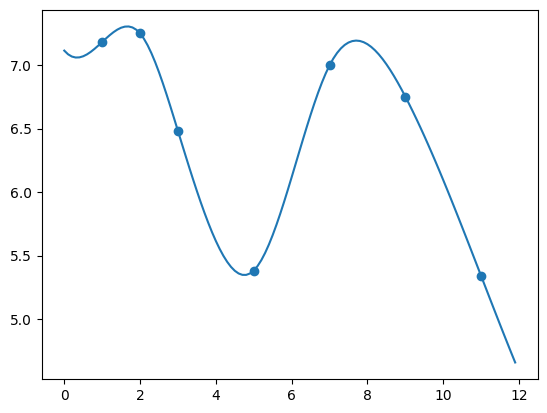

In [10]:
# 插值
ncs = Natural_cubic_spline(x, y);
ncs.fit()
yq = ncs.eval(xq)

plt.scatter(x,y)
plt.plot(xq,yq)

### 4.2 夹持边界条件
只需要继承自然边界条件, 对列出的方程稍作修改即可


In [12]:
class Clamped_cubic_spline(Natural_cubic_spline):
    def __init__(self,x,y,A,B):
        super().__init__(x,y)
        self.A = A
        self.B = B
    def _gen_equation(self):
        #单独定义函数：生成方程的系数
        #-----------------------------
        v1 = self.h.copy() #v1表示对H矩阵对角线左侧的值      

        v2 = 2*np.ones(len(x)) #v2表示对H矩阵对角线值 
        v2[1:-1] = 2*(self.h[:-1]+self.h[1:])
        v2[0] =2* self.h[0]
        v2[-1] =2* self.h[-1]

        v3 = self.h.copy() #v3表示对H矩阵对角线右侧的值

        H = np.diag(v1,-1) + np.diag(v2,0) + np.diag(v3,1)

        d = np.zeros(len(x))
        d[1:-1] = 6*(self.dy[1:]/self.h[1:] - self.dy[:-1]/self.h[:-1]) 
        d[0] = 6*(self.dy[0]/self.h[0] - self.A)
        d[-1] = 6*(self.B - self.dy[-1]/self.h[-1])

        return H,d

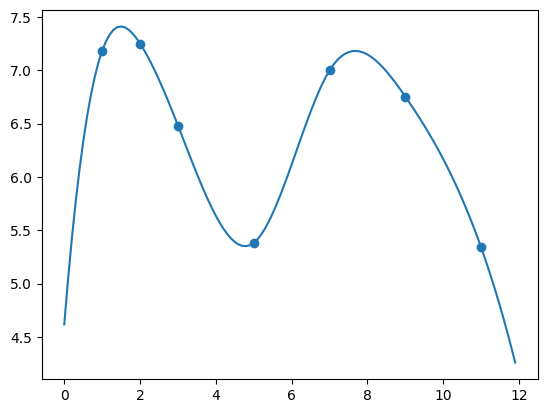

In [13]:
# 插值
ccs = Clamped_cubic_spline(x, y, 1, -1)
ccs.fit()
yq = ccs.eval(xq)

plt.scatter(x,y)
plt.plot(xq,yq)

### 4.3 非扭结边界条件
同样要继承自然边界条件, 对列出的方程稍作修改即可;但不同的是, 非扭节推导出的矩阵H不再是三对角矩阵


In [17]:
class NaK_cubic_spline(Natural_cubic_spline):
    def __init__(self,x,y):
        super().__init__(x,y)
    def _gen_equation(self):
        #单独定义函数：生成方程的系数
        #-----------------------------
        v1 = self.h.copy() #v1表示对H矩阵对角线左侧的值      
        v1[-1] = v1[-1] + self.h[-2]

        v2 = 2*np.ones(len(x)) #v2表示对H矩阵对角线值 
        v2[1:-1] = 2*(self.h[:-1]+self.h[1:])
        v2[0] =- self.h[0]
        v2[-1] =-self.h[-2]

        v3 = self.h.copy() #v3表示对H矩阵对角线右侧的值
        v3[0] = v3[0] + self.h[1]

        H = np.diag(v1,-1) + np.diag(v2,0) + np.diag(v3,1)
        H[0,2] = -self.h[0]
        H[-1,-3] = -self.h[-1]

        d = np.zeros(len(x))
        d[1:-1] = 6*(self.dy[1:]/self.h[1:] - self.dy[:-1]/self.h[:-1]) 
        return H,d

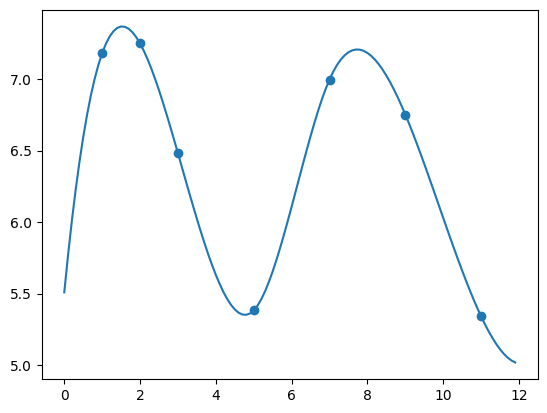

In [18]:
nkcs = NaK_cubic_spline(x,y)
nkcs.fit()
yq = nkcs.eval(xq)
plt.scatter(x,y)
plt.plot(xq,yq)

最后对比边界条件的差异

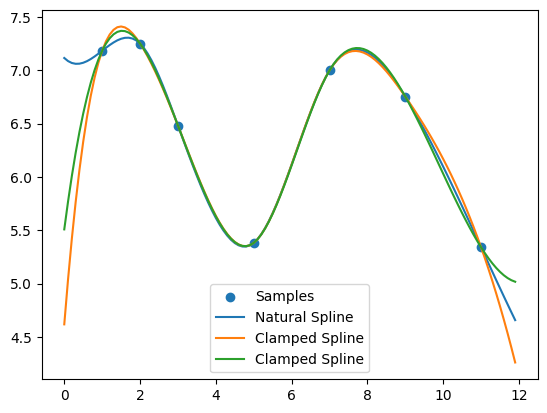

In [19]:
yq_n = ncs.eval(xq)
yq_c = ccs.eval(xq)
yq_k = nkcs.eval(xq)
plt.scatter(x,y)
plt.plot(xq,yq_n)
plt.plot(xq,yq_c)
plt.plot(xq,yq_k)
plt.legend(["Samples", "Natural Spline", "Clamped Spline", "Clamped Spline"])

## 5 实现三对角矩阵算法
上面调用了numpy的函数求解线性方程组, 我们可以针对三对角矩阵的特点用专用的三对角矩阵求解算法提高求解效率, 同时减少依赖, 更容易移植到c++等不方便使用线性代数库的程序中.

这里采用TDMA算法, 并且采用该算法后, 不需要一个方阵H来存储三个对角线上的元素, 这样可以节省存储空间.


In [20]:
# use Thomas Method to solve tridiagonal linear equation
# algorithm reference: https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm

import numpy as np

# parameter: a,b,c,d are list-like of same length
# tridiagonal linear equation: Ax=d
# b: main diagonal of matrix A
# a: main diagonal below of matrix A
# c: main diagonal upper of matrix A
# d: Ax=d
# return: x(type=list), the solution of Ax=d
def TDMA(a,b,c,d):

    try:
        n = len(d)    # order of tridiagonal square matrix

        # use a,b,c to create matrix A, which is not necessary in the algorithm
        A = np.array([[0]*n]*n, dtype='float64')

        for i in range(n):
            A[i,i] = b[i]
            if i > 0:
                A[i, i-1] = a[i]
            if i < n-1:
                A[i, i+1] = c[i]

        # new list of modified coefficients
        c_1 = [0]*n
        d_1 = [0]*n

        for i in range(n):
            if not i:
                c_1[i] = c[i]/b[i]
                d_1[i] = d[i] / b[i]
            else:
                c_1[i] = c[i]/(b[i]-c_1[i-1]*a[i])
                d_1[i] = (d[i]-d_1[i-1]*a[i])/(b[i]-c_1[i-1] * a[i])

        # x: solution of Ax=d
        x = [0]*n

        for i in range(n-1, -1, -1):
            if i == n-1:
                x[i] = d_1[i]
            else:
                x[i] = d_1[i]-c_1[i]*x[i+1]

        x = [round(_, 4) for _ in x]

        return x

    except Exception as e:
        return e

def main():

    a = [0, 1, 1, 1, 1]
    b = [4, 4, 4, 4, 4]
    c = [1, 1, 1, 1, 0]
    d = [1, 0.5, -1, 3, 2]

    '''
    a = [0, 2, 1, 3]
    b = [1, 1, 2, 1]
    c = [2, 3, 0.5, 0]
    d = [2, -1, 1, 3]
    '''

    x = TDMA(a, b, c, d)
    print('The solution is %s'%x)

main()

The solution is [0.2, 0.2, -0.5, 0.8, 0.3]
